# Filtros de respuesta al impulso finita o no recursivos (FIR)
<img src="./img/logo_UTN.svg" align="right" width="150" /> 

#### Por Mariano Llamedo Soria

### Resumen 

En este notebook se ejemplifica el diseño de filtros FIR mediante las funciones de síntesis digital directa de [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html).

* Funciones de análisis de sistemas lineales: [plot_plantilla]() 
* Funciones de diseño digital [firwin2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin2.html#scipy.signal.firwin2), [firls](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firls.html#scipy.signal.firls), [remez.](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.remez.html#scipy.signal.remez)



Se inicializa el entorno de simulación con los módulos utilizados.


In [1]:

import sympy as sp
import numpy as np
import scipy.signal as sig
from scipy.signal.windows import hamming, kaiser, blackmanharris
import matplotlib.pyplot as plt

from pytc2.sistemas_lineales import plot_plantilla, group_delay


### Introducción

Como los filtros FIR no tienen contraparte analógica, es decir no pueden diseñarse mediante la  transformada bilineal, continuaremos con el enfoque de [síntesis directa presentado para los IIR](filtros_IIR.ipynb), haciendo énfasis en las diferencias más importantes.

Lo primero que hay que mencionar es que existen dos tipos de funciones de diseño de filtros FIR:

* Métodos de ventanas: es un método **no iterativo**, que ante una plantilla de diseño válida, **garantiza siempre un filtro digital diseñado** (aunque sub-óptimo).
* Métodos **iterativos**: son los más eficientes, ya que los filtros que generan se consideran óptimos, siempre que el algoritmo que los calcula logre converger. Serán óptimos en el sentido que cumplirán una plantilla de requerimientos con la **menor cantidad de coeficientes**.

### Método de ventanas

Es un método muy sencillo para el diseño de filtros FIR que consta de los siguientes pasos:

1. Definición de la respuesta en frecuencia deseada. Esto no necesariamente debe ser un filtro pasabajos, pasabanda o *notch*, podría ser cualquier función deseada $H_d[k]$. Por ejemplo para un pasabajo:
$$
H_d[k] = \begin{cases}
1, & \text{para } 0 \leq k \leq K \\
0, & \text{para } K+1 \leq k \leq N-1
\end{cases}
$$
 Si bien esta respuesta podría pensarse que corresponde a un *brick-wall*, está lejos de serlo dado que solo contempla una longitud de N muestras.

2. En consecuencia, podemos calcular la respuesta al impulso de un filtro de este tipo mediante la DFT inversa:
$$
h_d[n] = \frac{1}{N} \sum_{k=0}^{N-1} H_d[k] e^{j\frac{2\pi}{N}kn}
$$
3. Elegir una ventana **adecuada** para el filtro a implementar. Este paso requiere entender las características de las ventanas y los requerimientos del uso que se le dará al filtro. En nuestro caso utilizaremos la ventana de [Hamming](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.hamming.html#scipy.signal.windows.hamming):
$$
w[n] = 0.54 - 0.46 \cos\left(\frac{2\pi n}{N}\right)
$$
4. Calcular los coeficientes del filtro como:
$$ h[n] = h_d[n] \cdot w[n] $$ 

De esta manera, y utilizando todo el arsenal de ventanas disponible en [scipy.signal.windows](https://docs.scipy.org/doc/scipy/reference/signal.windows.html#module-scipy.signal.windows), podemos diseñar muy sencillamente cualquier tipo de filtro, o sistema de respuesta finita al impulso.

A continuación continuamos el ejemplo con el que trabajamos en los notebooks anteriores.

In [2]:
# frecuencia de muestreo normalizada
fs = 2.0
# tamaño de la respuesta al impulso
cant_coef = 27

filter_type = 'lowpass'

fpass = 0.25 # 
ripple = 0.5 # dB
fstop = 0.6 # Hz
attenuation = 40 # dB

# construyo la plantilla de requerimientos
frecs = [0.0,  fpass,     fstop,          1.0]
gains = [0,   -ripple, -attenuation,   -np.inf] # dB

gains = 10**(np.array(gains)/20)

# algunas ventanas para evaluar
#win_name = 'boxcar'
#win_name = 
win_name = kaiser
#win_name = 'flattop'

# FIR design
num_bh = sig.firwin2(cant_coef, frecs, gains , window='blackmanharris' )
num_hm = sig.firwin2(cant_coef, frecs, gains , window='hamming' )
num_ka = sig.firwin2(cant_coef, frecs, gains , window=('kaiser',14))
den = 1.0


Como se compararán diferentes filtros y configuraciones, es conveniente diseñar una función para analizar la respuesta en frecuencia de filtros FIR, como se muestra a continuación.

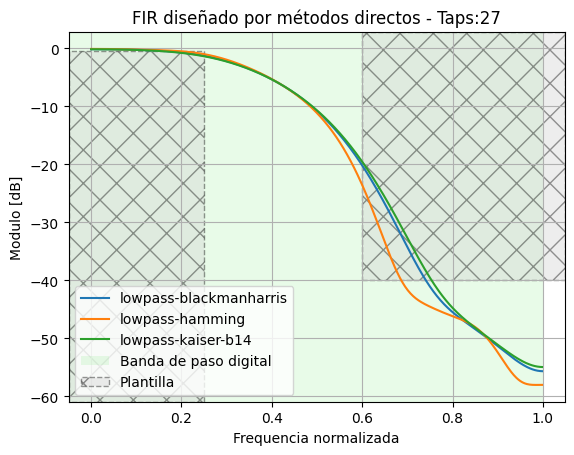

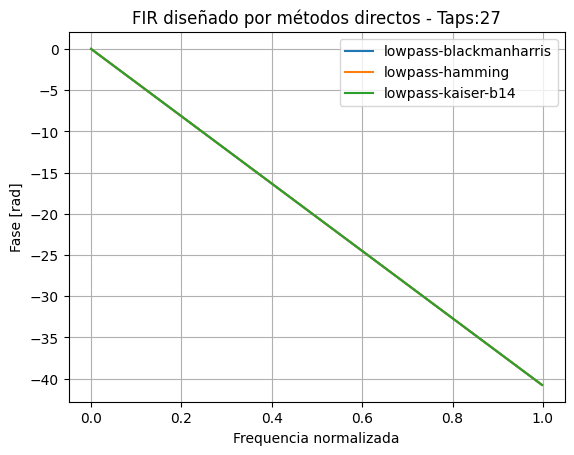

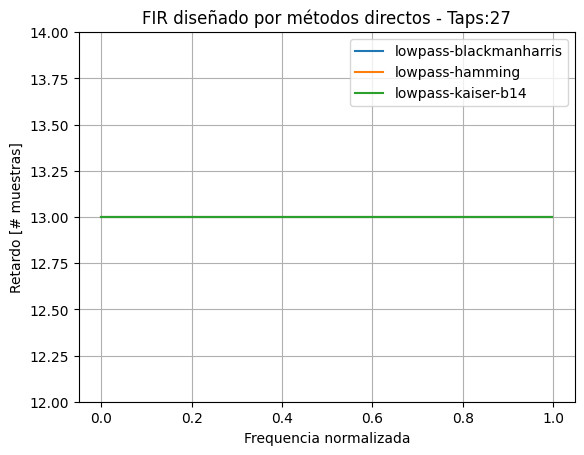

In [3]:
def plot_freq_resp_fir(this_num, this_desc):

    wrad, hh = sig.freqz(this_num, 1.0)
    ww = wrad / np.pi
    
    plt.figure(1)

    plt.plot(ww, 20 * np.log10(abs(hh)), label=this_desc)

    plt.title('FIR diseñado por métodos directos - Taps:' + str(cant_coef) )
    plt.xlabel('Frequencia normalizada')
    plt.ylabel('Modulo [dB]')
    plt.grid(which='both', axis='both')

    axes_hdl = plt.gca()
    axes_hdl.legend()
    
    plt.figure(2)

    phase = np.unwrap(np.angle(hh))

    plt.plot(ww, phase, label=this_desc)

    plt.title('FIR diseñado por métodos directos - Taps:' + str(cant_coef))
    plt.xlabel('Frequencia normalizada')
    plt.ylabel('Fase [rad]')
    plt.grid(which='both', axis='both')

    axes_hdl = plt.gca()
    axes_hdl.legend()

    plt.figure(3)

    # ojo al escalar Omega y luego calcular la derivada.
    gd_win = group_delay(wrad, phase)

    plt.plot(ww, gd_win, label=this_desc)

    plt.ylim((np.min(gd_win[2:-2])-1, np.max(gd_win[2:-2])+1))
    plt.title('FIR diseñado por métodos directos - Taps:' + str(cant_coef))
    plt.xlabel('Frequencia normalizada')
    plt.ylabel('Retardo [# muestras]')
    plt.grid(which='both', axis='both')

    axes_hdl = plt.gca()
    axes_hdl.legend()    

plot_freq_resp_fir(num_bh, filter_type+ '-blackmanharris')    
plot_freq_resp_fir(num_hm, filter_type+ '-hamming')    
plot_freq_resp_fir(num_ka, filter_type+ '-kaiser-b14')    
    
    
# sobreimprimimos la plantilla del filtro requerido para mejorar la visualización    
fig = plt.figure(1)    
plot_plantilla(filter_type = filter_type , fpass = fpass, ripple = ripple , fstop = fstop, attenuation = attenuation, fs = fs)
ax = plt.gca()
ax.legend()

# reordenamos las figuras en el orden habitual: módulo-fase-retardo
plt.figure(2)    
axes_hdl = plt.gca()
axes_hdl.legend()

plt.figure(3)    
axes_hdl = plt.gca()
axes_hdl.legend()

plt.show()


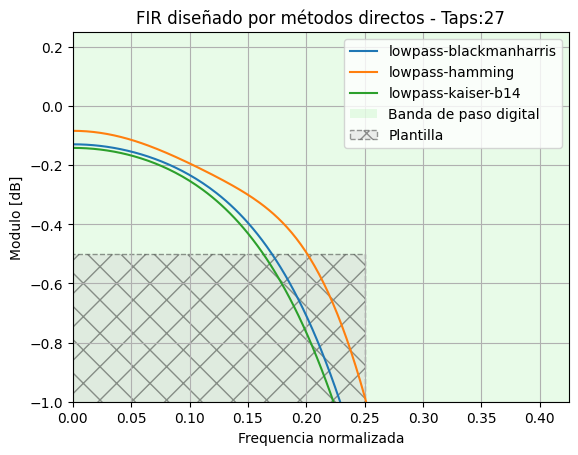

In [4]:
ax.set_xlim([0, np.mean((fpass,fstop))])
ax.set_ylim([-2*ripple, np.mean((-ripple,1)) ])
fig

Como se puede ver, el diseño del filtro **no** depende de la plantilla de requerimientos, y requiere un ajuste **artesanal** de cada filtro que se diseñe. Esto si bien es una dificultad, en la práctica no es tan complicado dado que con algo de práctica se logra diseñar casi cualquier filtro en pocas iteraciones. Se ejemplifica a continuación el procedimiento, mostrando solamente la iteración final, en la que se logra cumplir con la plantilla. 

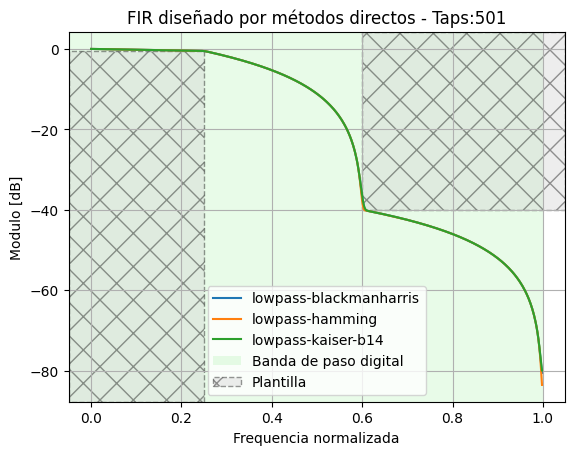

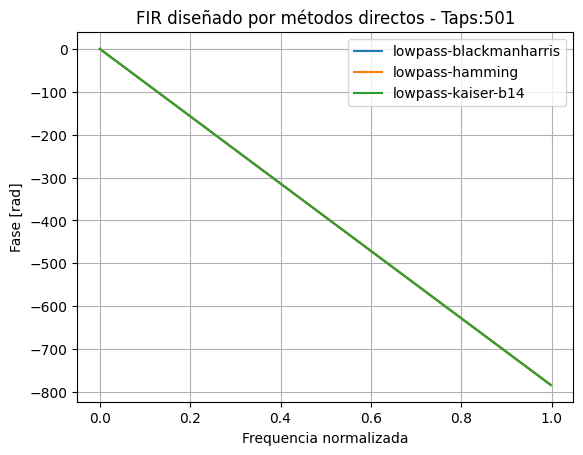

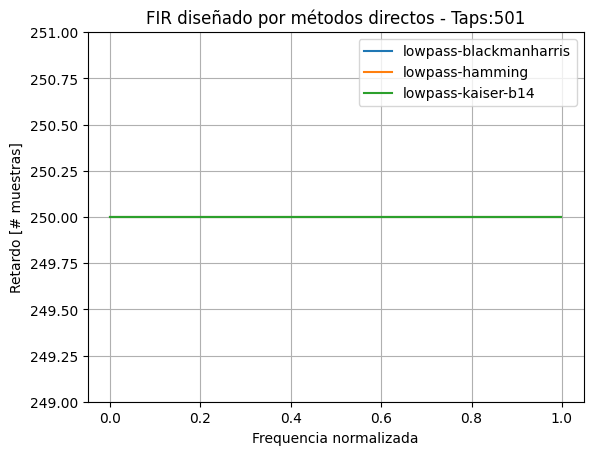

In [5]:
# segunda iteración: se aumenta el tamaño de la respuesta al impulso
cant_coef = 501

# FIR re-design
num_bh = sig.firwin2(cant_coef, frecs, gains , window='blackmanharris' )
num_hm = sig.firwin2(cant_coef, frecs, gains , window='hamming' )
num_ka = sig.firwin2(cant_coef, frecs, gains , window=('kaiser',14))

# visualizamos respuesta
plot_freq_resp_fir(num_bh, filter_type+ '-blackmanharris')    
plot_freq_resp_fir(num_hm, filter_type+ '-hamming')    
plot_freq_resp_fir(num_ka, filter_type+ '-kaiser-b14')    
    
    
# sobreimprimimos la plantilla del filtro requerido para mejorar la visualización    
fig = plt.figure(1)    
plot_plantilla(filter_type = filter_type , fpass = fpass, ripple = ripple , fstop = fstop, attenuation = attenuation, fs = fs)
ax = plt.gca()
ax.legend()

# reordenamos las figuras en el orden habitual: módulo-fase-retardo
plt.figure(2)    
axes_hdl = plt.gca()
axes_hdl.legend()

plt.figure(3)    
axes_hdl = plt.gca()
axes_hdl.legend()

plt.show()



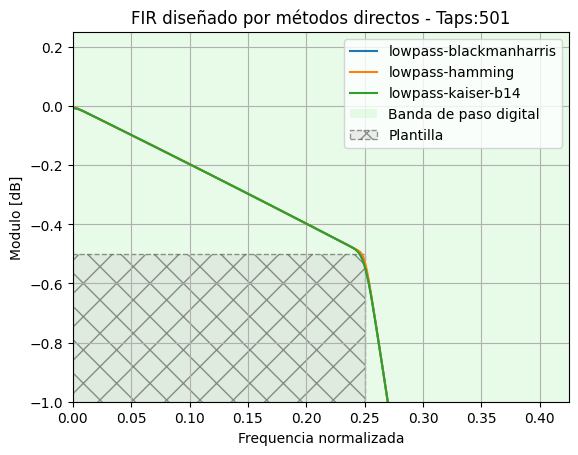

In [6]:
ax.set_xlim([0, np.mean((fpass,fstop))])
ax.set_ylim([-2*ripple, np.mean((-ripple,1)) ])
fig

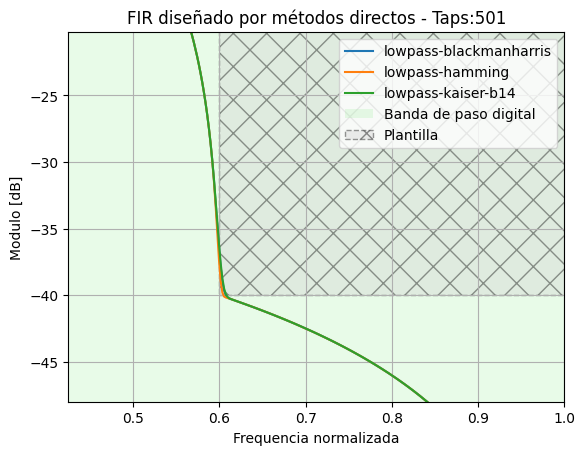

In [7]:
ax.set_xlim([np.mean((fpass,fstop)), 1.0])
ax.set_ylim([-1.2*attenuation, np.mean((-ripple,-attenuation))])
fig

De esta manera se logra cumplir con la plantilla, al igual que los IIR, pero para un filtro FIR de orden **MUY** superior (501 vs. 5). Esto lógicamente conlleva un **costo computacional más elevado**, aunqe tiene ventajas muy evidentes, como la **estabilidad garantizada**. Por otro lado, notar la respuesta  de fase es **perfectamente lineal**, y en consecuencia, su **retardo constante**. Esto si bien es una característica **muy deseable**, también hay que destacar que el retardo es **mucho mayor**.

Conviene destacar antes de continuar con métodos más sofisticados, alguna ventaja no tan evidente del método que acabamos de revisar:
1. Destacar la **simplicidad y fiabilidad** del método. Si definimos una plantilla de requerimientos válida, el diseño de un filtro digital aproximado para el orden prescrito está **garantizado**. 
2. Una plantilla válida puede generarse *casi* con cualquier función $H_d[k]$ que, al menos, pueda definirse a tramos. Esto quiere decir que las plantillas no necesariamente se corresponden con los típicos filtros (pasabanda, eliminabanda, etc.), sino que puede ser cualquier sistema lineal. Este tipo de sistemas han demostrado utilidad para infinidad de tareas, como ponderadores, sistemas adaptativos, etc. A continuación se ilustrará con un ejemplo final.


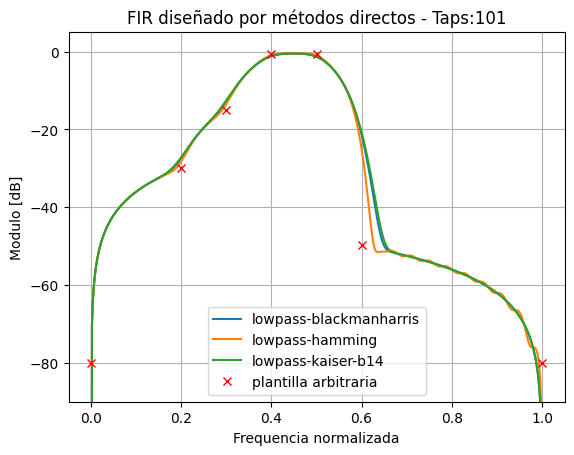

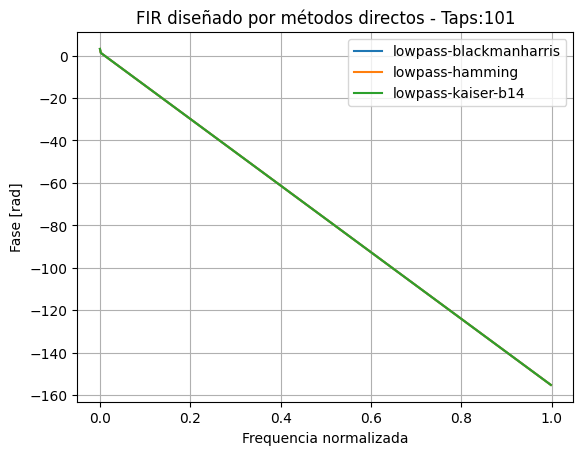

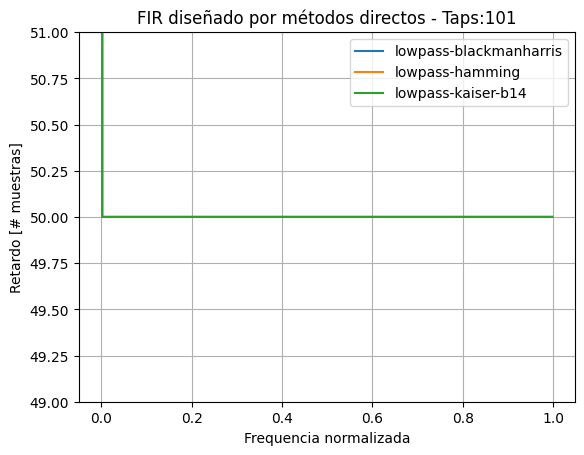

In [8]:
# probaremos ahora diseñar una respuesta arbitraria
frecs = [0.0,        0.2,     0.3,     0.4,      0.5,    0.6,   1.0 ]
gains = [-np.inf,   -30,      -15,   -ripple,   -ripple, -50,  -np.inf] # dB

gains = 10**(np.array(gains)/20)
    
# podemos usar los ceros estructurales de los FIR tipo 3-4 para forzar
# sendos ceros en DC-Nyquist. Recordar que necesitamos cantidad par
# de coeffs y antisimetría de la respuesta al impulso.
cant_coef = 101
fs = 2.0

# FIR re-design
num_bh = sig.firwin2(cant_coef, frecs, gains , window='blackmanharris', antisymmetric=True )
num_hm = sig.firwin2(cant_coef, frecs, gains , window='hamming', antisymmetric=True )
num_ka = sig.firwin2(cant_coef, frecs, gains , window=('kaiser',14), antisymmetric=True)

# visualizamos respuesta
plot_freq_resp_fir(num_bh, filter_type+ '-blackmanharris')    
plot_freq_resp_fir(num_hm, filter_type+ '-hamming')    
plot_freq_resp_fir(num_ka, filter_type+ '-kaiser-b14')    
    
    
# sobreimprimimos la plantilla del filtro requerido para mejorar la visualización    
plt.figure(1)    
plt.plot(frecs, 20*np.log10(gains+1e-4), 'rx', label='plantilla arbitraria' )
axes_hdl = plt.gca()
axes_hdl.legend()
axes_hdl.set_ylim(bottom=-90, top=5)

# reordenamos las figuras en el orden habitual: módulo-fase-retardo
plt.figure(2)    
axes_hdl = plt.gca()
axes_hdl.legend()

plt.figure(3)    
axes_hdl = plt.gca()
axes_hdl.legend()

plt.show()


### Cuadrados mínimos

Se describe a continuación un método basado en álgebra matricial, tras resolver un problema de cuadrados mínimos dado por:

[1] Ivan Selesnick, [Linear-Phase Fir Filter Design By Least Squares.](https://dl.icdst.org/pdfs/files2/db4bfe63bf3123e5a16dbc240b682109.pdf)



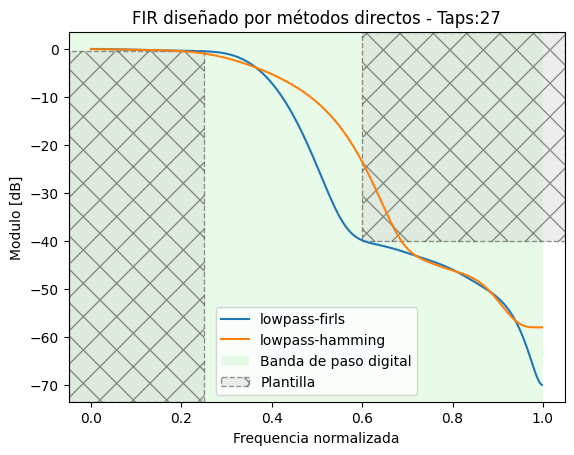

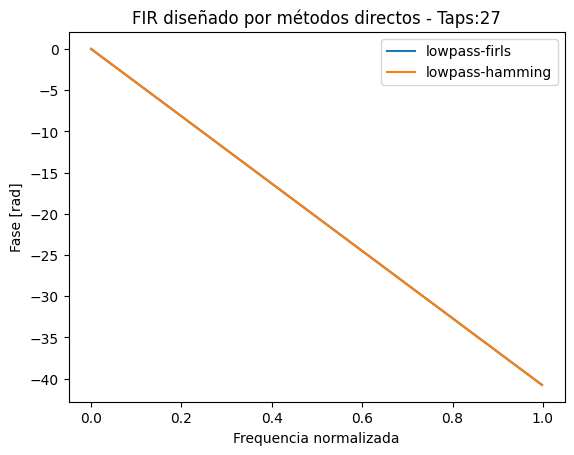

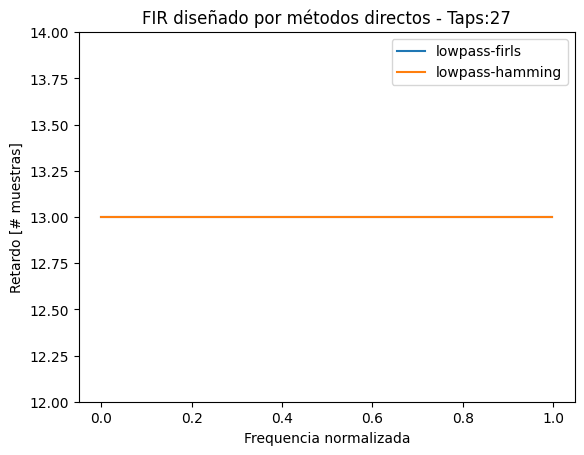

In [9]:
# frecuencia de muestreo normalizada
fs = 2.0
# tamaño de la respuesta al impulso
cant_coef = 27

filter_type = 'lowpass'

fpass = 0.25 # 
ripple = 0.5 # dB
fstop = 0.6 # Hz
attenuation = 40 # dB

# construyo la plantilla de requerimientos
frecs = [0.0,  fpass,     fstop,          1.0]
gains = [0,   -ripple, -attenuation,   -np.inf] # dB

gains = 10**(np.array(gains)/20)

num_firls = sig.firls(cant_coef, frecs, gains, fs=fs)
num_hm = sig.firwin2(cant_coef, frecs, gains , window='hamming' )


plot_freq_resp_fir(num_firls, filter_type + '-firls')    
plot_freq_resp_fir(num_hm, filter_type + '-hamming')    
  
# sobreimprimimos la plantilla del filtro requerido para mejorar la visualización    
plt.figure(1)    
plot_plantilla(filter_type = filter_type , fpass = fpass, ripple = ripple , fstop = fstop, attenuation = attenuation, fs = fs)
axes_hdl = plt.gca()
axes_hdl.legend()

# reordenamos las figuras en el orden habitual: módulo-fase-retardo
plt.figure(2)    
axes_hdl = plt.gca()
axes_hdl.legend()

plt.figure(3)    
axes_hdl = plt.gca()
axes_hdl.legend()

plt.show()


### Métodos iterativos: Parks-McClellan/Remez exchange algorithm

Calcula un filtro digital óptimo en el sentido *minimax* utilizando el algoritmo *Remez-exchange*.

[1] J. H. McClellan and T. W. Parks, [A unified approach to the
   design of optimum FIR linear phase digital filters](https://ieeexplore.ieee.org/abstract/document/1083764),
   IEEE Trans. Circuit Theory, vol. CT-20, pp. 697-701, 1973.
   
[2] J. H. McClellan, T. W. Parks and L. R. Rabiner, [A Computer
   Program for Designing Optimum FIR Linear Phase Digital
   Filters](https://web.ece.ucsb.edu/Faculty/Rabiner/ece259/Reprints/062_computer%20program.pdf), IEEE Trans. Audio Electroacoust., vol. AU-21,
   pp. 506-525, 1973.


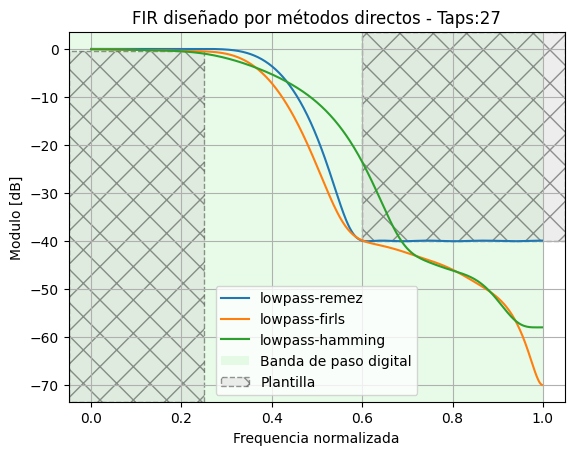

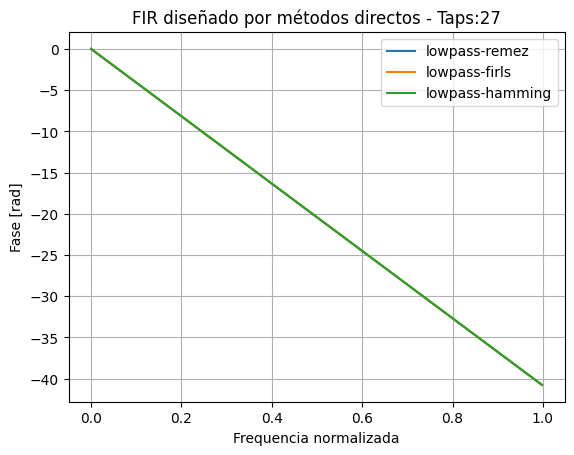

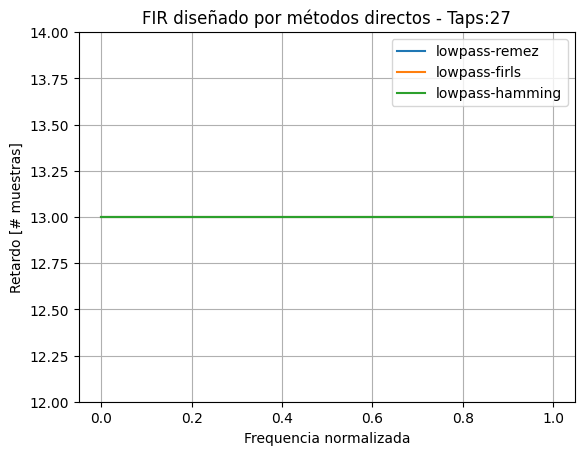

In [10]:

num_firls = sig.firls(cant_coef, frecs, gains, fs=fs)
num_hm = sig.firwin2(cant_coef, frecs, gains , window='hamming' )
num_remez = sig.remez(cant_coef, frecs, gains[::2], fs=fs)


plot_freq_resp_fir(num_remez, filter_type + '-remez')    
plot_freq_resp_fir(num_firls, filter_type + '-firls')    
plot_freq_resp_fir(num_hm, filter_type + '-hamming')    
  
# sobreimprimimos la plantilla del filtro requerido para mejorar la visualización    
plt.figure(1)    
plot_plantilla(filter_type = filter_type , fpass = fpass, ripple = ripple , fstop = fstop, attenuation = attenuation, fs = fs)
axes_hdl = plt.gca()
axes_hdl.legend()

# reordenamos las figuras en el orden habitual: módulo-fase-retardo
plt.figure(2)    
axes_hdl = plt.gca()
axes_hdl.legend()

plt.figure(3)    
axes_hdl = plt.gca()
axes_hdl.legend()

plt.show()


### Conclusiones

En este notebook se presentaron los métodos disponibles en [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html) para el diseño de filtros FIR, ordenados por creciente complejidad:

1. Ventanas [(firwin2)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin2.html#scipy.signal.firwin2)
2. Cuadrados mínimos  [(firls)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firls.html#scipy.signal.firls)
3. Parks-McClellan/Remez exchange [(remez)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.remez.html#scipy.signal.remez)

De los tres algoritmos, el de **remez** es el que ha diseñado filtros con mejor desempeño, es decir, cuyas respuestas en frecuencia satisfacen una plantilla para un orden dado. Sin embargo, su naturaleza iterativa y su complejidad algorítmica puede ser una limitación en circunstancias donde los requerimientos son muy exigentes (problemas de convergencia). Por este motivo no debe menospreciarse el uso de los otros métodos, ya que su simplicidad y garantía de funcionamiento, especialmente **firlms**, los posiciona como herramientas muy útiles para el procesamiento digital de señales.
